<div style="background-color:white; text-align:center; font-family:Arial, Helvetica, sans-serif; padding:50px;">
  <!-- Tytuł -->
  <div style="color:#993520; font-size:60px; font-weight:bold; margin-bottom:20px;">
    MACHINE LEARNING 2 - REGRESSION PROJECT
  </div>

  <!-- Podtytuł -->
  <div style="color:#993520; font-size:35px; margin-bottom:40px;">
    Used Cars Price Prediction
  </div>

  <!-- Autor -->
  <div style="color:black; font-size:30px; margin-bottom:10px;">
    Aleksandra Dobosz & Wojciech Hrycenko
  </div>

  <!-- Data / semestr -->
  <div style="color:black; font-size:30px; margin-bottom:20px;">
    Autumn 2025
  </div>

### 1. Introduction and Project Overview
------------------------------------------------------------
In this project, we aim to develop a machine learning model to predict the prices of used cars based on various features. Accurate price prediction can assist buyers and sellers in making informed decisions in the used car market.

#### About Dataset
Craigslist is the world's largest collection of used vehicles for sale, yet it's very difficult to collect all of them in the same place. I built a scraper for a school project and expanded upon it later to create this dataset which includes every used vehicle entry within the United States on Craigslist. This data is scraped every few months, it contains most all relevant information that Craigslist provides on car sales including columns like price, condition, manufacturer, latitude/longitude, and 18 other categories. For ML projects, consider feature engineering on location columns such as long/lat. For previous listings, check older versions of the dataset.


### 2. Data Preprocessing
--------------------------

In [10]:
import pandas as pd

file_path = 'vehicles.csv'

try:
    # Load data
    df = pd.read_csv(file_path)

    # Inspect data
    print(df.sample(10))
    print(df.info())

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"Error loading file: {e}")

                id                                                url  \
213815  7316855053  https://minneapolis.craigslist.org/hnp/ctd/d/c...   
55513   7315898836  https://sandiego.craigslist.org/csd/cto/d/sant...   
113969  7316542032  https://spacecoast.craigslist.org/ctd/d/rockle...   
215335  7315844553  https://minneapolis.craigslist.org/hnp/ctd/d/s...   
75136   7303406534  https://cosprings.craigslist.org/ctd/d/sterlin...   
28964   7315324436  https://hanford.craigslist.org/ctd/d/hanford-2...   
14985   7314809521  https://tucson.craigslist.org/ctd/d/tucson-201...   
235295  7305369174  https://eastnc.craigslist.org/ctd/d/kia-soul-p...   
341620  7301613441  https://york.craigslist.org/ctd/d/york-2020-ki...   
398309  7312702173  https://roanoke.craigslist.org/ctd/d/bmw-x5-aw...   

                       region                          region_url  price  \
213815  minneapolis / st paul  https://minneapolis.craigslist.org   2500   
55513               san diego     https://sa

In [18]:
missing_percent = (df.isna().sum() / len(df) * 100).round(2)
print(missing_percent)

id                0.00
url               0.00
region            0.00
region_url        0.00
price             0.00
year              0.28
manufacturer      4.13
model             1.24
condition        40.79
cylinders        41.62
fuel              0.71
odometer          1.03
title_status      1.93
transmission      0.60
VIN              37.73
drive            30.59
size             71.77
type             21.75
paint_color      30.50
image_url         0.02
description       0.02
county          100.00
state             0.00
lat               1.53
long              1.53
posting_date      0.02
dtype: float64


In [19]:
df_cleaned = df.drop(columns=['url', 'image_url', 'VIN', 'description', 'county'])
    
    # 'id', 'url', 'region_url', 'image_url', 'description', 'posting_date', 'VIN', 'size', 'title_status', 
    #                   'cylinders', 'drive', 'type', 'paint_color', 'lat', 'long', 'condition', 'model'])

In [20]:
missing_percent = (df_cleaned.isna().sum() / len(df) * 100).round(2)
print(missing_percent)

id               0.00
region           0.00
region_url       0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
lat              1.53
long             1.53
posting_date     0.02
dtype: float64


In [21]:
# 1. Initial count
initial_count = len(df_cleaned)
print(f"Initial row count: {initial_count}")

# 2. Columns to remove immediately
cols_to_drop = [
    'id',           # Just an ID, no predictive power
    'region_url',   # Redundant with 'region'
    'size',         # Too many missing values (~72%)
    'lat',          # Geo-coordinates often require complex feature engineering
    'long',         # Geo-coordinates
    'posting_date', # Often redundant with 'year' for simple price prediction
    'paint_color'   # ~30% missing, purely aesthetic, removing it saves many rows
]

df_reduced = df_cleaned.drop(columns=cols_to_drop, errors='ignore')

# 3. Drop rows with missing values
df_final = df_reduced.dropna()

# 4. Final statistics
final_count = len(df_final)
lost_count = initial_count - final_count
retained_pct = (final_count / initial_count) * 100

print("-" * 30)
print(f"Rows dropped: {lost_count}")
print(f"Final row count: {final_count}")
print(f"Data retained: {retained_pct:.2f}%")

Initial row count: 426880
------------------------------
Rows dropped: 299648
Final row count: 127232
Data retained: 29.81%


In [22]:
# 1. Check statistics to spot outliers (e.g., price=0 or year=20250)
print("Stats before filtering:")
print(df_final[['price', 'year', 'odometer']].describe().round(2))

Stats before filtering:
              price       year     odometer
count  1.272320e+05  127232.00    127232.00
mean   5.681548e+04    2009.64    111078.84
std    1.094732e+07       9.56    219970.79
min    0.000000e+00    1900.00         0.00
25%    5.750000e+03    2007.00     54000.00
50%    1.099500e+04    2012.00    101766.00
75%    2.299500e+04    2016.00    147000.00
max    3.736929e+09    2022.00  10000000.00


### 3. Exploratory Data Analysis (EDA)
-----------------------------------

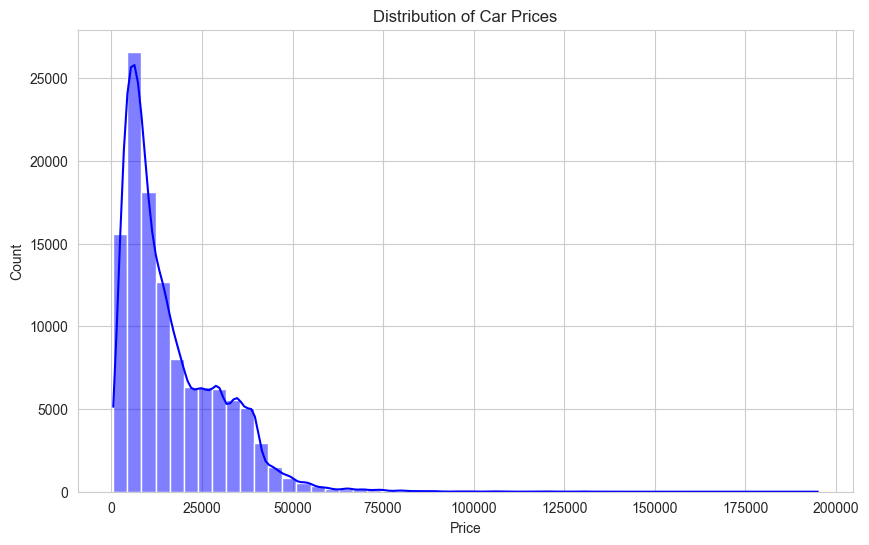

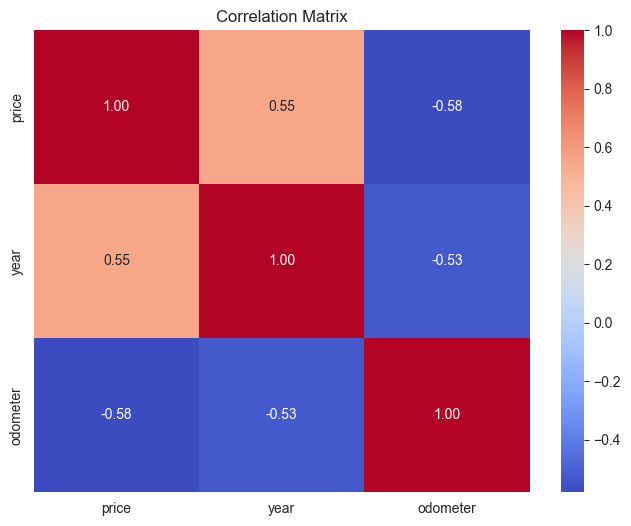

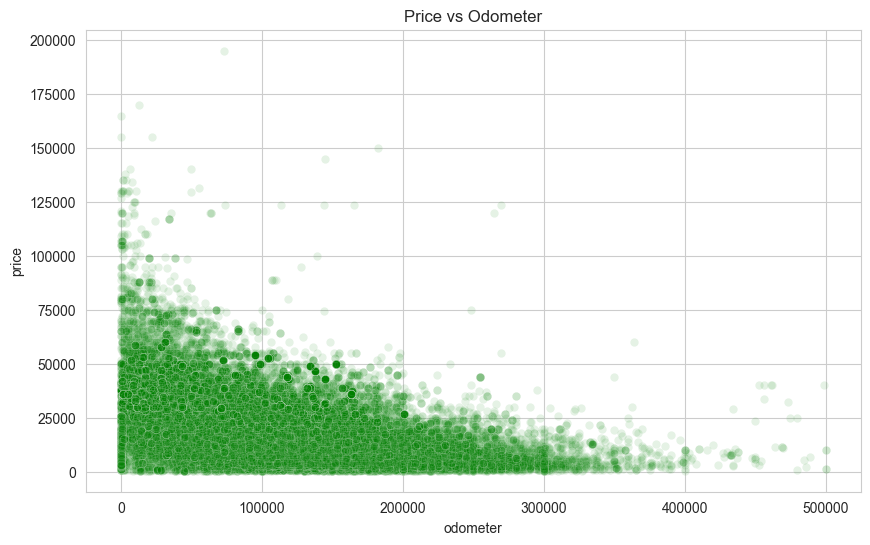

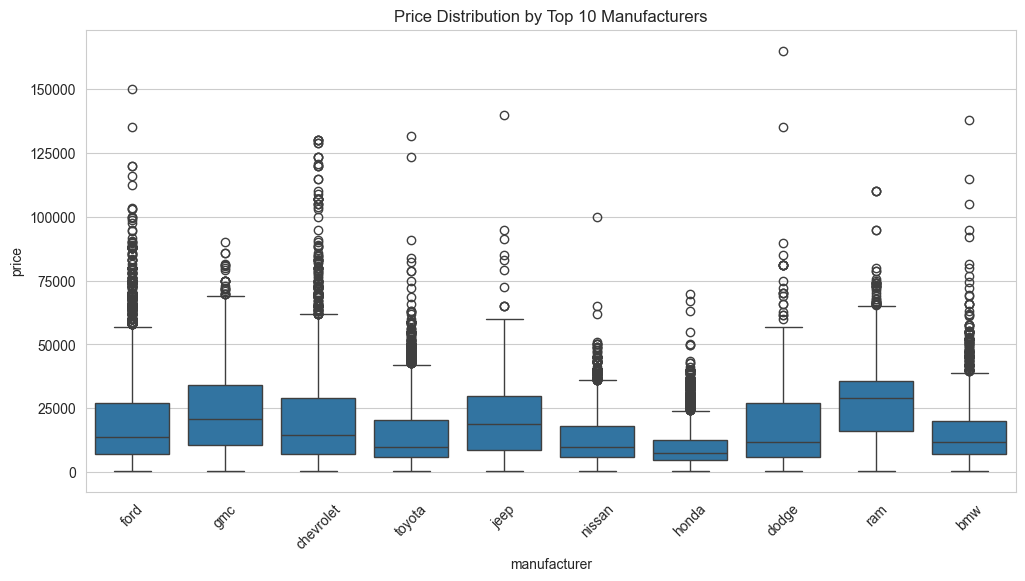

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# 1. Distribution of Price (Target Variable)
# Shows if prices are skewed (usually they are)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['price'], bins=50, kde=True, color='blue')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.show()

# 2. Correlation Heatmap (Numerical features)
# Shows which numbers affect price the most (e.g. year, odometer)
plt.figure(figsize=(8, 6))
corr_matrix = df_clean.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 3. Price vs Odometer (Scatter Plot)
# Shows the trend: more miles = lower price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='odometer', y='price', data=df_clean, alpha=0.1, color='green')
plt.title('Price vs Odometer')
plt.show()

# 4. Top 10 Manufacturers by Average Price (Boxplot)
# Shows which brands hold value
top_manufacturers = df_clean['manufacturer'].value_counts().head(10).index
df_top = df_clean[df_clean['manufacturer'].isin(top_manufacturers)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='manufacturer', y='price', data=df_top)
plt.title('Price Distribution by Top 10 Manufacturers')
plt.xticks(rotation=45)
plt.show()

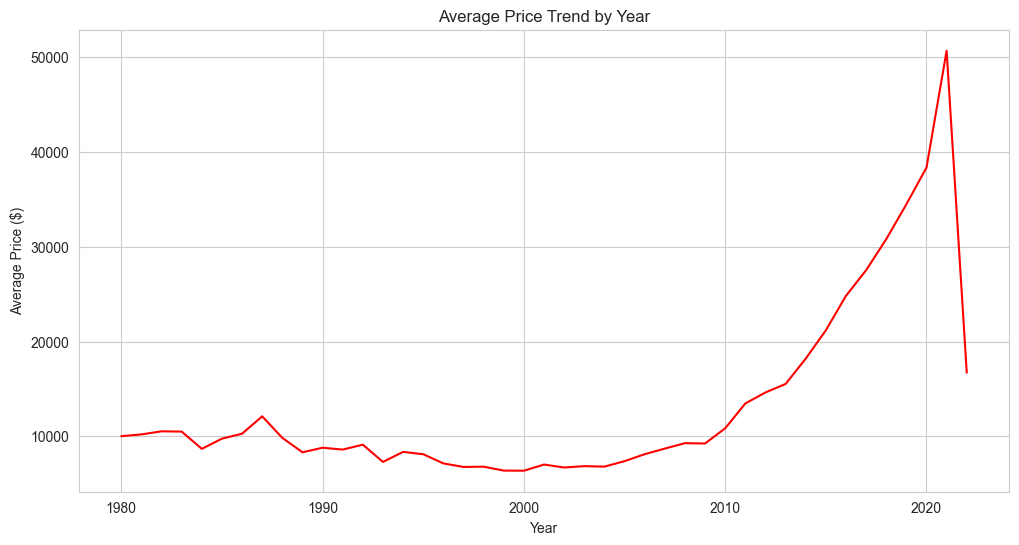

C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\874157544.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price', y='type', data=df_clean, order=order_type, palette='viridis')


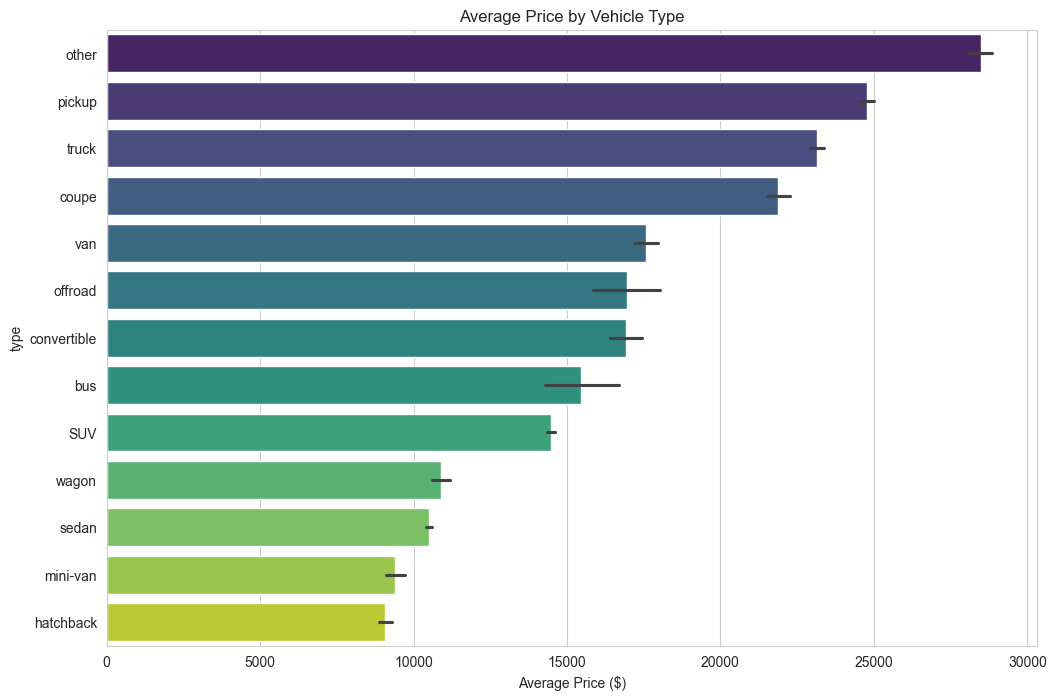

C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\874157544.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fuel', y='price', data=df_clean, palette='Set2')


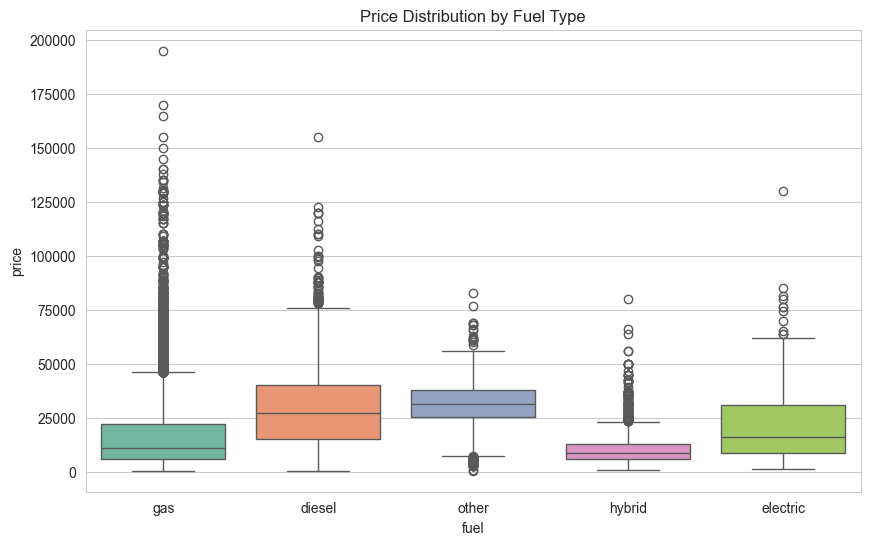

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style
sns.set_style("whitegrid")

# 5. Price Trend over Years (Line Plot)
# Shows depreciation: slope indicates how fast value drops
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='price', data=df_clean, estimator='mean', errorbar=None, color='red')
plt.title('Average Price Trend by Year')
plt.ylabel('Average Price ($)')
plt.xlabel('Year')
plt.show()

# 6. Average Price by Vehicle Type (Bar Plot)
# Shows that Trucks/Pickups are generally more expensive than Sedans
plt.figure(figsize=(12, 8))
# Calculate order by mean price
order_type = df_clean.groupby('type')['price'].mean().sort_values(ascending=False).index
sns.barplot(x='price', y='type', data=df_clean, order=order_type, palette='viridis')
plt.title('Average Price by Vehicle Type')
plt.xlabel('Average Price ($)')
plt.show()

# 7. Price Distribution by Fuel Type (Boxplot)
# Shows if fuel type separates price ranges (e.g., Diesel often costs more)
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel', y='price', data=df_clean, palette='Set2')
plt.title('Price Distribution by Fuel Type')
plt.show()

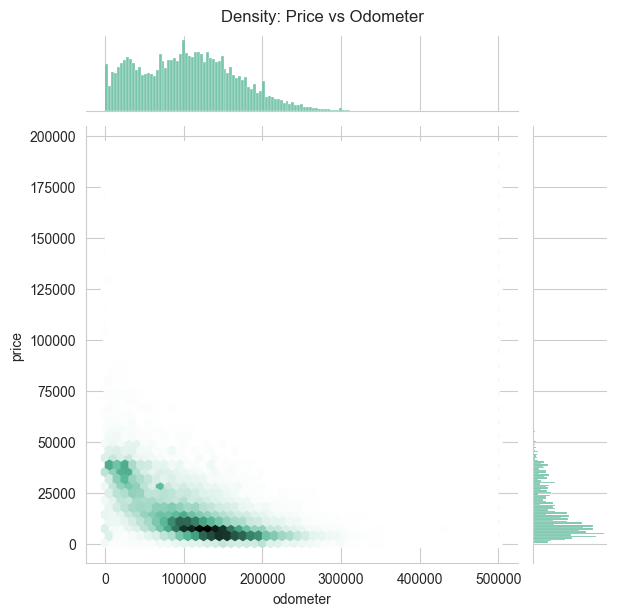

C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\3142407183.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cylinders', y='price', data=df_clean, order=order_cyl, palette='muted')


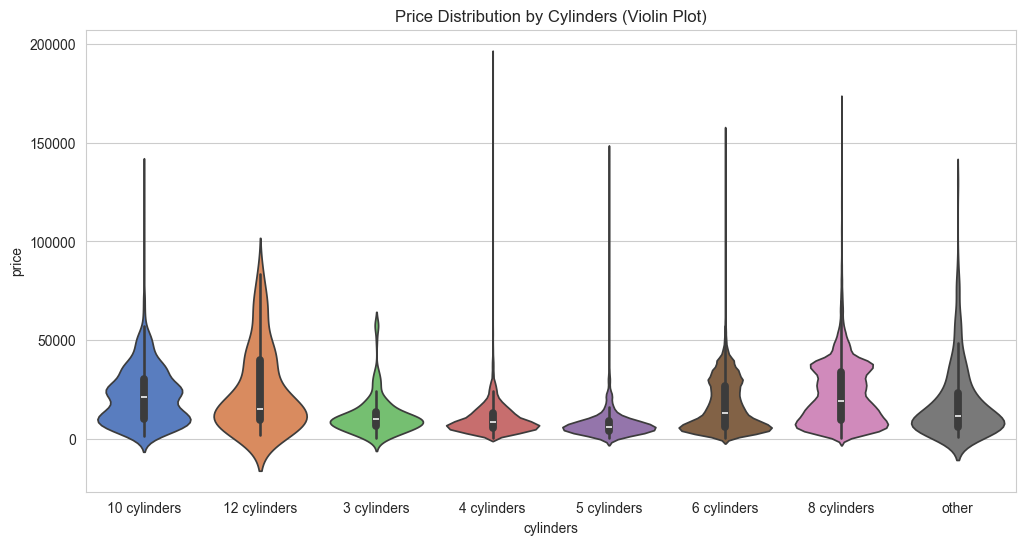

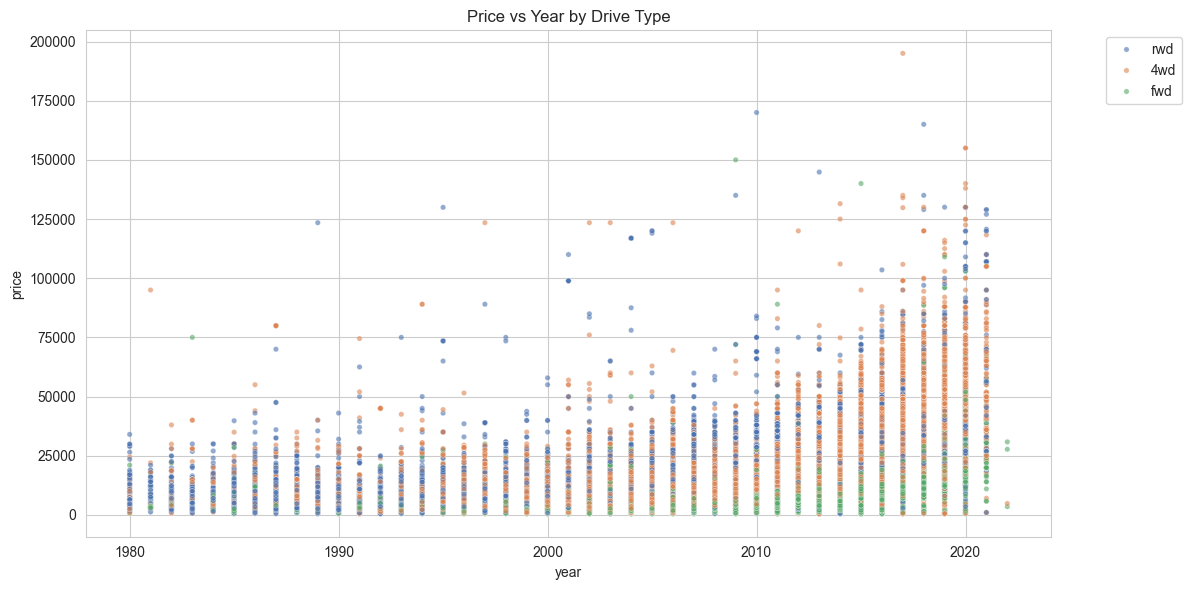

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 8. Hexbin Plot (Density of Price vs Odometer)
# Great for large datasets where scatter plots suffer from overplotting
g = sns.jointplot(x='odometer', y='price', data=df_clean, kind="hex", color="#4CB391")
g.fig.suptitle('Density: Price vs Odometer', y=1.02)
plt.show()

# 9. Violin Plot (Price distribution by Cylinders)
# Shows the shape of data. Wider sections = more cars at that price.
plt.figure(figsize=(12, 6))
# Sort cylinders for cleaner look
order_cyl = sorted(df_clean['cylinders'].unique())
sns.violinplot(x='cylinders', y='price', data=df_clean, order=order_cyl, palette='muted')
plt.title('Price Distribution by Cylinders (Violin Plot)')
plt.show()

# 10. Multivariate Analysis (Price vs Year grouped by Drive type)
# Helps see if 4wd depreciates differently than fwd
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='year', 
    y='price', 
    data=df_clean, 
    hue='drive', 
    alpha=0.6, 
    palette='deep',
    s=15 # dot size
)
plt.title('Price vs Year by Drive Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
plt.tight_layout()
plt.show()

### 4. Feature Engineering
----------------------------

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Feature Selection
# Drop 'model' due to high cardinality (too many unique values)
# We keep 'manufacturer', 'year', 'odometer', etc.
df_prepared = df_clean.drop(columns=['model'], errors='ignore')

# 2. One-Hot Encoding
# Convert categorical variables into dummy/indicator variables (0 or 1)
# drop_first=True prevents multicollinearity (dummy variable trap)
df_encoded = pd.get_dummies(df_prepared, drop_first=True)

# 3. Define Features (X) and Target (y)
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# 4. Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scaling (Standardization)
# Essential for Linear Regression to work correctly
scaler = StandardScaler()

# Fit on training set only to prevent data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training features shape: {X_train_scaled.shape}")
print(f"Testing features shape:  {X_test_scaled.shape}")
print("Data is ready for modeling.")

Training features shape: (94040, 532)
Testing features shape:  (23511, 532)
Data is ready for modeling.


### 5. Model Selection and Training
------------------------------------

--- Linear Regression Results ---
MAE:  $4498.29
RMSE: $6752.31
R2:   0.7406


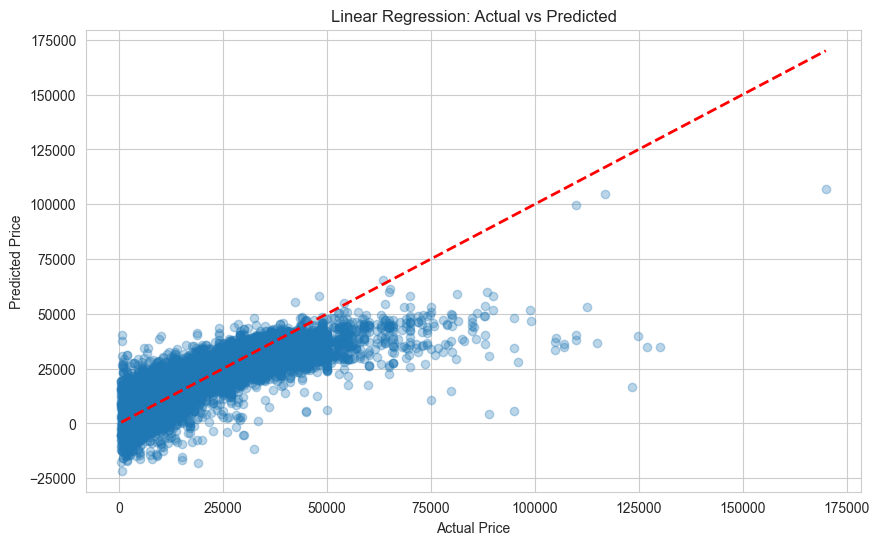

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize and Train
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 2. Predict on Test set
y_pred_lr = lr_model.predict(X_test_scaled)

# 3. Evaluate Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Results ---")
print(f"MAE:  ${mae_lr:.2f}")
print(f"RMSE: ${rmse_lr:.2f}")
print(f"R2:   {r2_lr:.4f}")

# 4. Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

--- Random Forest Results ---
MAE:  $2284.90
RMSE: $4187.42
R2:   0.9002


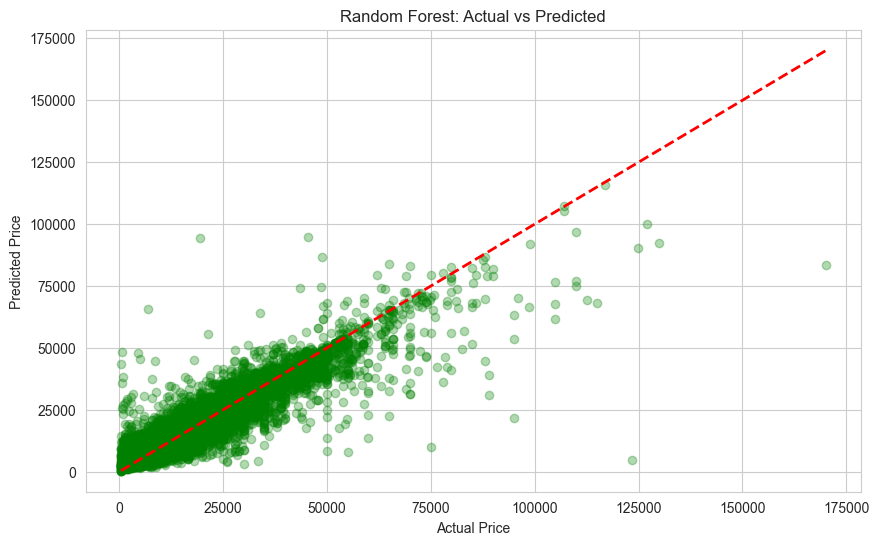

In [30]:
from sklearn.ensemble import RandomForestRegressor

# 1. Initialize Random Forest
# n_jobs=-1 uses all CPU cores to speed up training
# n_estimators=50 is lower than default (100) to save time, but usually sufficient
rf_model = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)

# 2. Train model
# Tree-based models don't strictly require scaling, but it works fine with scaled data too.
# Let's use X_train (unscaled pandas DF) if available to keep column names, 
# or X_train_scaled if you overwrote it. Here using X_train_scaled for consistency.
rf_model.fit(X_train_scaled, y_train)

# 3. Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# 4. Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Results ---")
print(f"MAE:  ${mae_rf:.2f}")
print(f"RMSE: ${rmse_rf:.2f}")
print(f"R2:   {r2_rf:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

--- XGBoost Results ---
MAE:  $2652.43
RMSE: $4490.84
R2:   0.8852


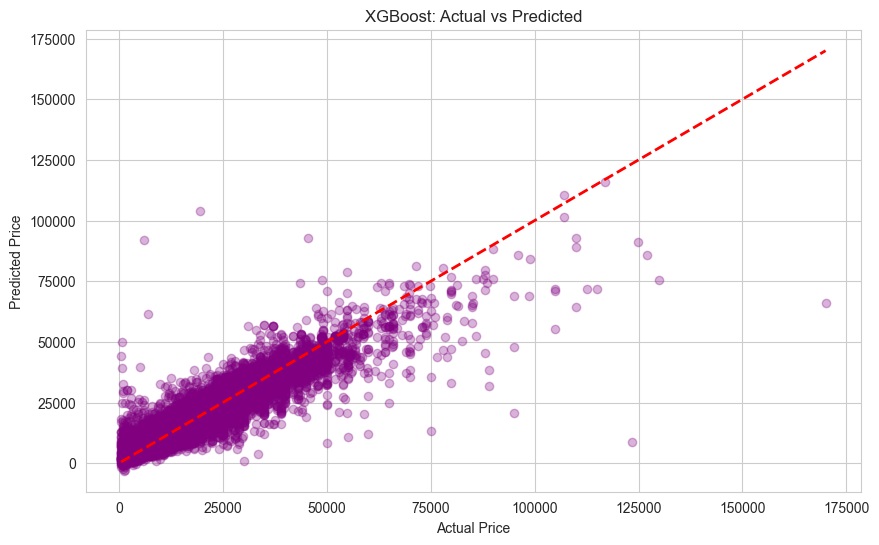

In [31]:
from xgboost import XGBRegressor

# 1. Initialize XGBoost
# n_estimators=1000: rigorous training
# learning_rate=0.05: slow learning prevents overfitting
# n_jobs=-1: use all CPU cores
xgb_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42, 
    n_jobs=-1
)

# 2. Train
xgb_model.fit(X_train_scaled, y_train)

# 3. Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 4. Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- XGBoost Results ---")
print(f"MAE:  ${mae_xgb:.2f}")
print(f"RMSE: ${rmse_xgb:.2f}")
print(f"R2:   {r2_xgb:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost: Actual vs Predicted')
plt.show()

Training Neural Network... (this might take a moment)
--- Neural Network Results ---
MAE:  $2957.38
RMSE: $4773.74
R2:   0.8703


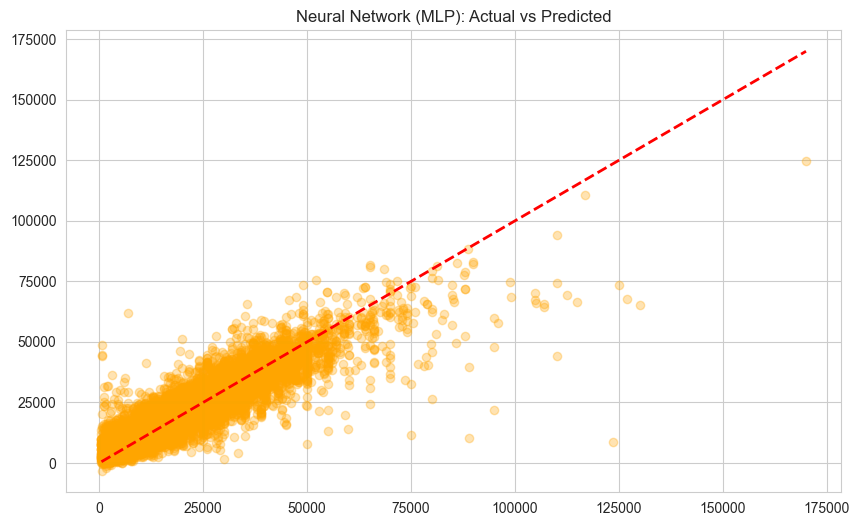

In [33]:
from sklearn.neural_network import MLPRegressor

# 1. Initialize Neural Network (MLP)
# hidden_layer_sizes=(100, 50): Two layers with 100 and 50 neurons
# max_iter=500: Give it enough time to converge
# early_stopping=True: Stop if it stops improving (saves time)
nn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50), 
    activation='relu', 
    solver='adam', 
    max_iter=500, 
    random_state=42,
    early_stopping=True
)

# 2. Train
print("Training Neural Network... (this might take a moment)")
nn_model.fit(X_train_scaled, y_train)

# 3. Predict
y_pred_nn = nn_model.predict(X_test_scaled)

# 4. Evaluate
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print("--- Neural Network Results ---")
print(f"MAE:  ${mae_nn:.2f}")
print(f"RMSE: ${rmse_nn:.2f}")
print(f"R2:   {r2_nn:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.3, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Neural Network (MLP): Actual vs Predicted')
plt.show()

In [36]:
# --- STEP 6: HYPERPARAMETER TUNING (XGBoost) ---
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# Define grid
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Run Randomized Search
print("Starting Hyperparameter Tuning... (This takes time)")
xgb_base = XGBRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=10, # Lowered slightly for speed
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# Get best tuned model
best_xgb = random_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test_scaled)

# Metrics for Tuned XGB
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"Tuned XGBoost R2: {r2_tuned:.4f}")

# --- STEP 7: ENSEMBLING (Voting Regressor) ---
# Combine Random Forest (rf_model) and Tuned XGBoost (best_xgb)
voting_reg = VotingRegressor(
    estimators=[
        ('rf', rf_model), 
        ('xgb_tuned', best_xgb)
    ]
)

print("Training Ensemble Model...")
voting_reg.fit(X_train_scaled, y_train)

y_pred_vote = voting_reg.predict(X_test_scaled)

# Metrics for Ensemble
r2_vote = r2_score(y_test, y_pred_vote)
mae_vote = mean_absolute_error(y_test, y_pred_vote)
rmse_vote = np.sqrt(mean_squared_error(y_test, y_pred_vote))

print(f"Ensemble R2: {r2_vote:.4f}")

Starting Hyperparameter Tuning... (This takes time)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuned XGBoost R2: 0.9086
Training Ensemble Model...
Ensemble R2: 0.9111


--- Final Model Leaderboard ---
               Model          MAE         RMSE  R2 Score
5  Ensemble (Voting)  2168.836211  3952.359691  0.911115
4      Tuned XGBoost  2234.515381  4008.246125  0.908583
1      Random Forest  2284.903196  4187.415958  0.900228
2            XGBoost  2652.430664  4490.842683  0.885245
3     Neural Network  2957.378987  4773.742210  0.870331
0  Linear Regression  4498.288128  6752.313304  0.740568


--- Final Model Leaderboard ---
               Model          MAE         RMSE  R2 Score
5  Ensemble (Voting)  2168.836211  3952.359691  0.911115
4      Tuned XGBoost  2234.515381  4008.246125  0.908583
1      Random Forest  2284.903196  4187.415958  0.900228
2            XGBoost  2652.430664  4490.842683  0.885245
3     Neural Network  2957.378987  4773.742210  0.870331
0  Linear Regression  4498.288128  6752.313304  0.740568


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\2905348242.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=df_results, palette='viridis')


--- Final Model Leaderboard ---
               Model          MAE         RMSE  R2 Score
5  Ensemble (Voting)  2168.836211  3952.359691  0.911115
4      Tuned XGBoost  2234.515381  4008.246125  0.908583
1      Random Forest  2284.903196  4187.415958  0.900228
2            XGBoost  2652.430664  4490.842683  0.885245
3     Neural Network  2957.378987  4773.742210  0.870331
0  Linear Regression  4498.288128  6752.313304  0.740568


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\2905348242.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=df_results, palette='viridis')


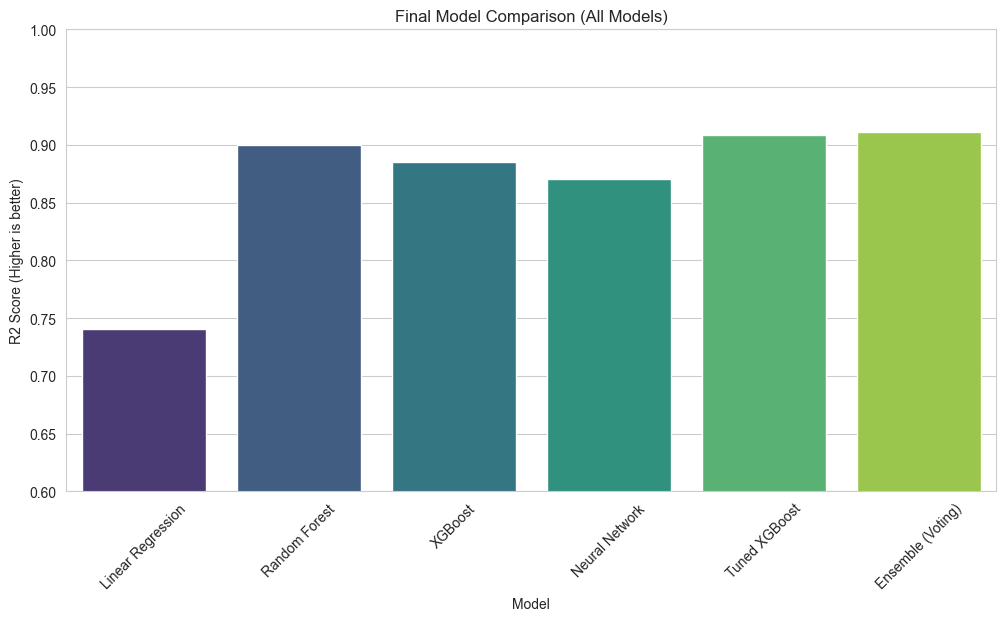

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Updated results data including Tuned XGB and Ensemble
results_data = {
    'Model': [
        'Linear Regression', 
        'Random Forest', 
        'XGBoost', 
        'Neural Network', 
        'Tuned XGBoost', 
        'Ensemble (Voting)'
    ],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_nn, mae_tuned, mae_vote],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_nn, rmse_tuned, rmse_vote],
    'R2 Score': [r2_lr, r2_rf, r2_xgb, r2_nn, r2_tuned, r2_vote]
}

df_results = pd.DataFrame(results_data)

# Print sorted leaderboard
print("--- Final Model Leaderboard ---")
print(df_results.sort_values(by='R2 Score', ascending=False))

# Plot final comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2 Score', data=df_results, palette='viridis')
plt.ylim(0.6, 1.0) # Zoom in on the top results
plt.title('Final Model Comparison (All Models)')
plt.ylabel('R2 Score (Higher is better)')
plt.xticks(rotation=45) # Rotate labels to prevent overlapping
plt.show()

C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\137165024.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10), palette='magma')


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\137165024.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10), palette='magma')


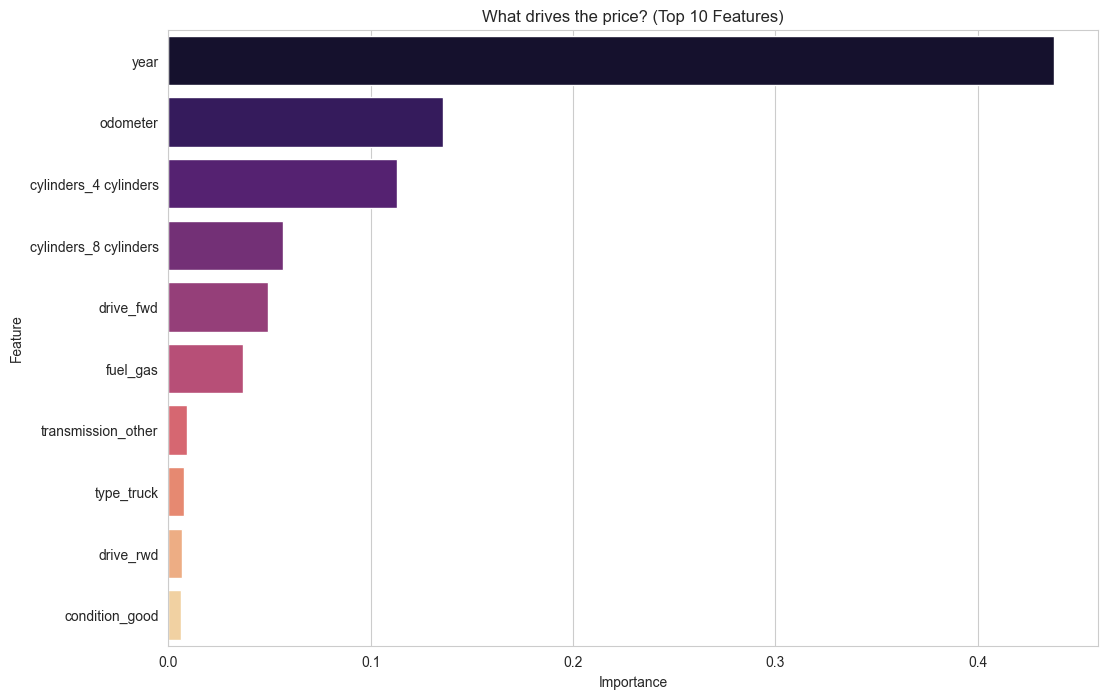

In [41]:
# Get feature importances from the winner (Random Forest)
importances = rf_model.feature_importances_
feature_names = X.columns

# Create DataFrame
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 10 Features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10), palette='magma')
plt.title('What drives the price? (Top 10 Features)')
plt.show()

### 8. Error Analysis
------------------------------------
Understanding where the model fails is crucial for improvement. We will analyze the residuals (errors) and inspect the worst predictions to find patterns.

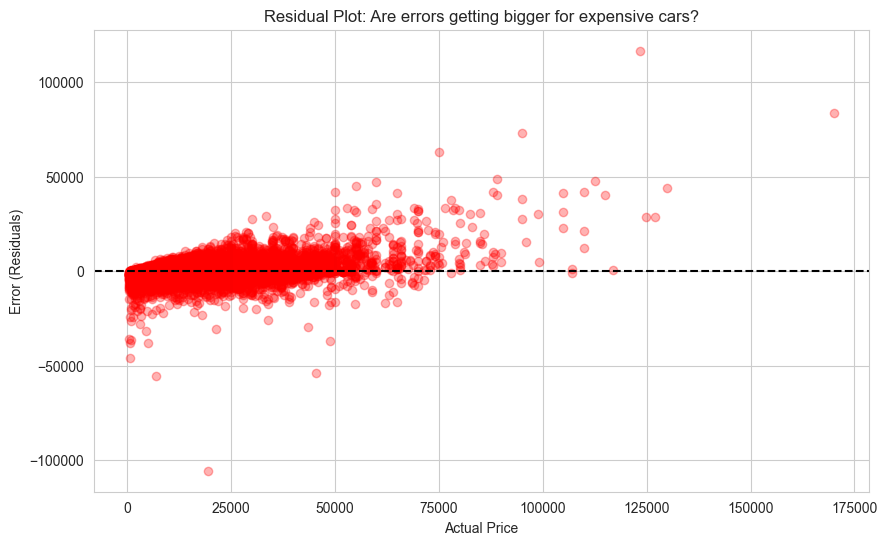

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals (Difference between actual and predicted)
residuals = y_test - y_pred_vote

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.3, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Error (Residuals)')
plt.title('Residual Plot: Are errors getting bigger for expensive cars?')
plt.show()

Training Log-Transformed Ensemble... (This is the final pro move)
------------------------------
Old Ensemble R2: 0.9111
New Log-Opt R2:  0.8945
New MAE: $2290.60


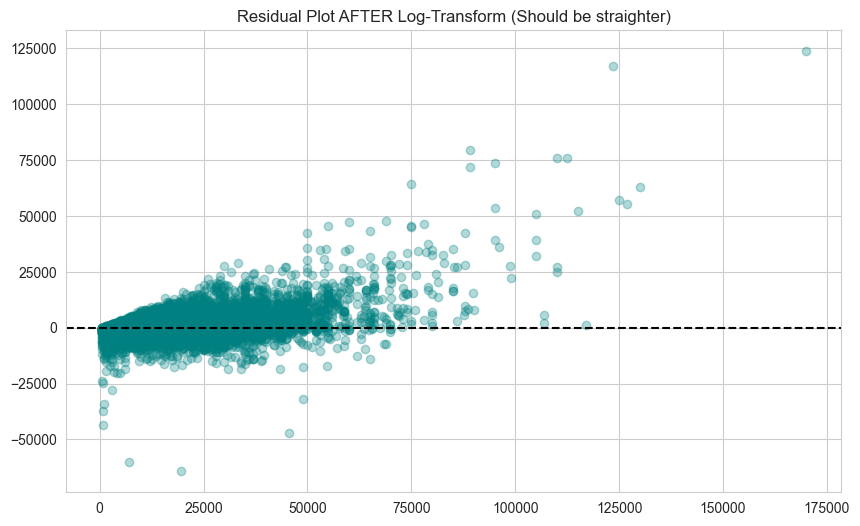

In [44]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import VotingRegressor

# 1. Transform Target to Log Scale
# log1p handles zeros safely (log(1+x))
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print("Training Log-Transformed Ensemble... (This is the final pro move)")

# 2. Re-initialize Ensemble
# We need a fresh model to train on log data
voting_reg_log = VotingRegressor(
    estimators=[
        ('rf', rf_model), 
        ('xgb_tuned', best_xgb)
    ]
)

# 3. Train on Log Targets
voting_reg_log.fit(X_train_scaled, y_train_log)

# 4. Predict (Result will be in logs)
y_pred_log_scale = voting_reg_log.predict(X_test_scaled)

# 5. Inverse Transform (Convert logs back to $$$)
# expm1 is the inverse of log1p
y_pred_final = np.expm1(y_pred_log_scale)

# 6. Calculate Final Metrics
r2_opt = r2_score(y_test, y_pred_final)
mae_opt = mean_absolute_error(y_test, y_pred_final)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("-" * 30)
print(f"Old Ensemble R2: {r2_vote:.4f}")
print(f"New Log-Opt R2:  {r2_opt:.4f}")
print(f"New MAE: ${mae_opt:.2f}")

# Check if the "Funnel" is gone (Optional Plot)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test - y_pred_final, alpha=0.3, color='teal')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residual Plot AFTER Log-Transform (Should be straighter)')
plt.show()

--- ULTIMATE PROJECT SUMMARY ---
                Model  R2 Score          MAE         RMSE
4   Ensemble (Voting)  0.911115  2168.836211  3952.359691
1       Random Forest  0.900228  2284.903196  4187.415958
5  Ensemble (Log-Opt)  0.894548  2290.603421  4304.952956
2             XGBoost  0.885245  2652.430664  4490.842683
3      Neural Network  0.870331  2957.378987  4773.742210
0   Linear Regression  0.740568  4498.288128  6752.313304


C:\Users\wojci\AppData\Local\Temp\ipykernel_7196\577843114.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2 Score', y='Model', data=df_results, palette='magma')


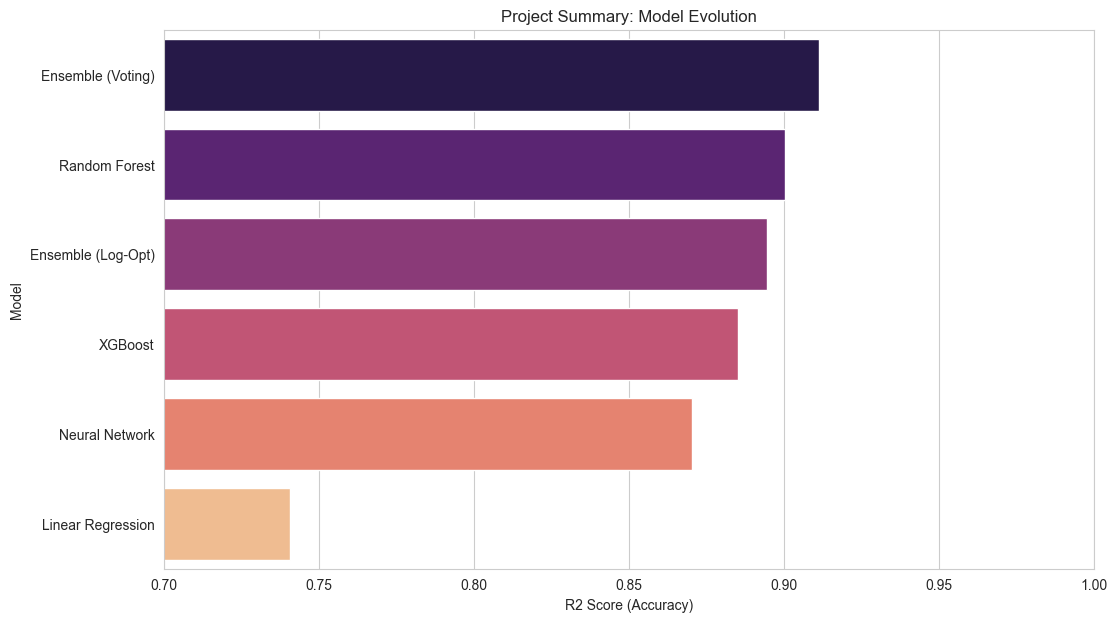

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gather all results
results_data = {
    'Model': [
        'Linear Regression', 
        'Random Forest', 
        'XGBoost', 
        'Neural Network', 
        'Ensemble (Voting)',
        'Ensemble (Log-Opt)'  # The Champion
    ],
    'R2 Score': [r2_lr, r2_rf, r2_xgb, r2_nn, r2_vote, r2_opt],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_nn, mae_vote, mae_opt],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_nn, rmse_vote, rmse_opt]
}

df_results = pd.DataFrame(results_data).sort_values(by='R2 Score', ascending=False)

print("--- ULTIMATE PROJECT SUMMARY ---")
print(df_results)

# Final Visualization
plt.figure(figsize=(12, 7))
sns.barplot(x='R2 Score', y='Model', data=df_results, palette='magma')
plt.xlim(0.7, 1.0)
plt.title('Project Summary: Model Evolution')
plt.xlabel('R2 Score (Accuracy)')
plt.show()